In [449]:
!pip install langchain_openai dotenv langgraph

In [450]:
from langchain_openai import ChatOpenAI

In [451]:
from dotenv import load_dotenv

In [452]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [453]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [454]:
openai_model=ChatOpenAI(model="gpt-4o")

In [455]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BNnC39yg1q8FqjYXptuB708XDiJm1', 'finish_reason': 'stop', 'logprobs': None}, id='run-2fd9aad8-819c-4c33-8d2c-ff137382699e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [456]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [457]:
state={}
state["messages"]=[]
state
state["messages"].append("hi")

In [458]:
state

{'messages': ['hi']}

In [459]:
state["messages"].append("how are you?")

In [460]:
state["messages"].append("what going on?")

In [461]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [462]:
from typing import Any, TypedDict, Annotated

In [463]:
class MessagesState(TypedDict):
    messages: Annotated[list[Any], add_messages]

In [464]:
## this state is a dict which containing the message as list and inside the list there could be n numbvers of messages

## this state will be flowing across all the nodes(function) in langgraph

In [465]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=openai_model.invoke(question)
    return {"messages":[response]}

In [466]:
workflow=StateGraph(MessagesState)

In [467]:
workflow.add_node("chatbot",call_model)

In [468]:
workflow.add_edge(START,"chatbot")

In [469]:
workflow.add_edge("chatbot",END)

In [470]:
app=workflow.compile()

In [471]:
from IPython.display import Image,display

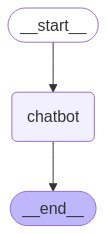

In [472]:
display(Image(app.get_graph().draw_mermaid_png()))

In [473]:
input={'messages': ['hi my name is sunny']}

In [474]:
input['messages']

['hi my name is sunny']

In [475]:
response=app.invoke(input)

In [476]:
response["messages"][-1].content

'Hello Sunny! How can I assist you today?'

In [477]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content='Hello Sunny! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BNnEJI8vmsCuY1rv82O27kgKII3q7', 'finish_reason': 'stop', 'logprobs': None}, id='run-6aea8479-46ab-4054-b73c-c4ee62b246f8-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}




In [478]:
@tool
def search(query:str):
    """this is a tool for weather checking"""
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [479]:
search.invoke("what is a weather in japan?")

'weather is cloudy with some darkness'

In [480]:
search.invoke("what is a weather in delhi?")

'the weather is hotty with some foggy'

In [481]:
tools=[search]

In [482]:
llm_with_tool=openai_model.bind_tools(tools)

In [483]:
response=llm_with_tool.invoke("hi")

In [484]:
response.content

'Hello! How can I assist you today?'

In [485]:
response.tool_calls

[]

In [489]:
result=llm_with_tool.invoke("what is a weather in europe?")

In [490]:
result.content

''

In [491]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current weather in Europe'},
  'id': 'call_hpWpG543jow2N3K5lvMK0L6H',
  'type': 'tool_call'}]

In [492]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [493]:
input={'messages': ['hi my name is sunny']}

In [494]:
response=call_model(input)

In [495]:
message=response["messages"]

In [496]:
last_message=message[-1]

In [497]:
last_message.content

'Hello Sunny! How can I assist you today?'

In [498]:
input={'messages': ['what is a weather in mumbai?']}

In [500]:
last_message.tool_calls

[]

In [499]:
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [501]:
tools

[StructuredTool(name='search', description='this is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x122d1fe20>)]

In [502]:
tool_node=ToolNode(tools)

In [503]:
workflow=StateGraph(MessagesState)

In [504]:
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)

In [505]:
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END})

app = workflow.compile()

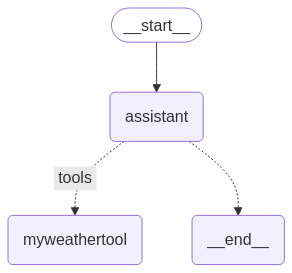

In [506]:
display(Image(app.get_graph().draw_mermaid_png()))

In [507]:
app.invoke({"messages": ["how are you?"]})

{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='6edaac27-cf0b-4717-b1f9-c3aa3eefa5f8'),
  AIMessage(content="I'm just a computer program, so I don't have feelings, but I'm here to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 48, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BOCrxsZtf6AWSr0pMUPJENSSZAYsw', 'finish_reason': 'stop', 'logprobs': None}, id='run-a32aad1d-7406-443a-978a-bc8e1115cb1f-0', usage_metadata={'input_tokens': 48, 'output_tokens': 28, 'total_tokens': 76, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'r

In [508]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='2950d102-adf5-4913-aad0-eaa1fbdc4a5a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YJ8BuunsSDGM3GolKwnUZVCE', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BOCsE0vwmMDXcpjJqsj65QBY3SyZY', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2af4b516-1b05-4527-8eb5-071a6eb45613-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'call_YJ8BuunsSDGM3GolKwnUZ

In [509]:
workflow.add_edge("myweathertool","assistant")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [510]:
app = workflow.compile()

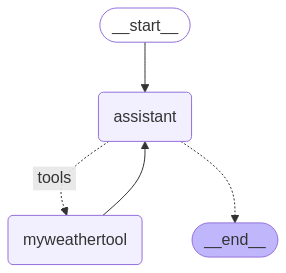

In [511]:
display(Image(app.get_graph().draw_mermaid_png()))

In [512]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='4ff642c9-4d3b-413b-90ae-190a145a4e31'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bxu1yU47onRQcljocMWS4sVQ', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BOCt29h8GAnALzKyCWRq5A1bJ5oDG', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b42b0cdc-4b4e-4998-8336-77ce39486afb-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'call_bxu1yU47onRQcljocMWS4

In [513]:
for output in app.stream({"messages": ["what is the weather in delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from assistant
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uF9Xh0IlkSBTiPLnB3WIpfVC', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BOCtRl3zTaY91D8Pk6Zf8F4QF3OvH', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-32f2ce88-187d-4a12-884f-10d85656e6cb-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'call_uF9Xh0IlkSBTiPLnB3WIpfVC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 66, 'inp

Reaserch and analsysis react agent: assisgnment

llm assistant
take a realtime weather api to check the real time weather detail
take a realtime api for checking realtime cricket score
take a tool for analysis the generated data(REPL)python code
create a report based on the generated data memory human in loop multiagentic flow
from next week onwards will implemnt the project